In [68]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from random import randrange, uniform

In [69]:
os.getcwd()

'C:\\Users\\sunny\\Python Codes\\cab fare prediction'

In [70]:
Train_Data=(pd.read_csv('train_cab.csv', header = 0 )).drop(columns="pickup_datetime")

In [71]:
Train_Data=Train_Data[np.logical_and(Train_Data['pickup_longitude'] != Train_Data['dropoff_longitude'],                                     Train_Data['pickup_latitude'] != Train_Data['dropoff_latitude'])]

In [72]:
Train_Data['fare_amount']= Train_Data['fare_amount'].apply(pd.to_numeric, errors='coerce')
Train_Data['fare_amount']= Train_Data['fare_amount'].replace({0:np.nan})
Train_Data['passenger_count']=Train_Data['passenger_count'].fillna(0)
Train_Data['passenger_count']= Train_Data['passenger_count'].astype(int)
Train_Data['passenger_count']=Train_Data['passenger_count'].replace({0: np.nan})
Train_Data['pickup_longitude']= Train_Data['pickup_longitude'].replace({0:np.nan})
Train_Data['pickup_latitude']= Train_Data['pickup_latitude'].replace({0:np.nan})
Train_Data['dropoff_longitude']= Train_Data['dropoff_longitude'].replace({0:np.nan})
Train_Data['dropoff_latitude']= Train_Data['dropoff_latitude'].replace({0:np.nan})

In [73]:
Train_Data.shape

(15603, 6)

In [74]:
Train_Data.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1.0


# Missing Value Analysis

In [75]:
#calculate missing values

missing_val = pd.DataFrame(Train_Data.isnull().sum())
#print(missing_val)

#Reset index
missing_val = missing_val.reset_index()


#Rename variable
missing_val = missing_val.rename(columns = {'index': 'Variables', 0: 'count'})

missing_val['Missing_percentage'] = (missing_val['count']/len(Train_Data)*100)

missing_val = missing_val.sort_values('Missing_percentage', ascending = False).reset_index(drop = True)
print(missing_val)
    

           Variables  count  Missing_percentage
0    passenger_count    112            0.717811
1        fare_amount     24            0.153817
2   pickup_longitude     12            0.076908
3    pickup_latitude     12            0.076908
4  dropoff_longitude     10            0.064090
5   dropoff_latitude      9            0.057681


# Missing Value Imputation

In [77]:
#Create missing value, a small test to identify which method is good for imputation

Train_Data["pickup_longitude"].loc[70]

-73.995781

In [78]:
Train_Data["pickup_longitude"].loc[70] = np.nan

In [79]:
Train_Data["pickup_longitude"].loc[70]

nan

In [83]:
Train_Data['fare_amount'] = Train_Data['fare_amount'].fillna(Train_Data['fare_amount'].mean())
Train_Data['pickup_longitude']= Train_Data['pickup_longitude'].fillna(Train_Data['pickup_longitude'].mean())
Train_Data['pickup_latitude']= Train_Data['pickup_latitude'].fillna(Train_Data['pickup_latitude'].mean())
Train_Data['dropoff_longitude']= Train_Data['dropoff_longitude'].fillna(Train_Data['dropoff_longitude'].mean())
Train_Data['dropoff_latitude']= Train_Data['dropoff_latitude'].fillna(Train_Data['dropoff_latitude'].mean())


Train_Data['passenger_count'] = Train_Data['passenger_count'].fillna(int(Train_Data['passenger_count'].mode()))

In [84]:
Train_Data=Train_Data.dropna()

In [85]:
convert_dic={'fare_amount' : 'float','passenger_count': 'int'}
Train_Data=Train_Data.astype(convert_dic)

In [86]:
Train_Data.shape

(15603, 6)

# Outlier Analysis

In [87]:
df = Train_Data.copy()
Train_Data = Train_Data.copy()

In [88]:

Train_Data.loc[Train_Data['fare_amount']<0 , 'fare_amount']=np.nan
Train_Data.loc[Train_Data['fare_amount'] > 30, 'fare_amount']=np.nan
Train_Data=Train_Data.dropna()

In [89]:
#irregular passenger counts or those wgich are greater then 8 convertet to NaN
Train_Data.loc[Train_Data['passenger_count'] > 8,'passenger_count'] = np.nan

In [90]:
coutliers = [ 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
for list in coutliers:
    q75, q25 = np.percentile(Train_Data[list], [75 ,25])
    iqr = q75 - q25
    minimum = q25 - (iqr*1.5)
    maximum = q75 + (iqr*1.5)

    # #Replace with NA
    Train_Data.loc[Train_Data[list] < minimum,list] = np.nan
    Train_Data.loc[Train_Data[list] > maximum,list] = np.nan

    # #Calculate missing value
    missing_val = pd.DataFrame(Train_Data.isnull().sum())
    


In [91]:
Train_Data['pickup_longitude'] = Train_Data['pickup_longitude'].fillna(Train_Data['pickup_longitude'].mean())
Train_Data['pickup_latitude'] = Train_Data['pickup_latitude'].fillna(Train_Data['pickup_latitude'].mean())
Train_Data['dropoff_longitude'] = Train_Data['dropoff_longitude'].fillna(Train_Data['dropoff_longitude'].mean())
Train_Data['dropoff_latitude'] = Train_Data['dropoff_latitude'].fillna(Train_Data['dropoff_latitude'].mean())

#imputed with mode for categorical variables
Train_Data['passenger_count'] = Train_Data['passenger_count'].fillna(int(Train_Data['passenger_count'].mode()))

In [92]:
#convert the data type of categorical variable passenger count
Train_Data['passenger_count']=Train_Data['passenger_count'].astype('int')
Train_Data['passenger_count']=Train_Data['passenger_count'].astype('category')

# Feature Selection

In [93]:
#haversine function

def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
   
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))


In [94]:
Train_Data['dist'] = \
    haversine( Train_Data['pickup_latitude'], Train_Data['pickup_longitude'],
                Train_Data['dropoff_latitude'], Train_Data['dropoff_longitude'])

In [95]:
##Correlation analysis
#Correlation plot
numeric=['fare_amount','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude', 'dist']
Train_Data_corr = Train_Data.loc[:,numeric]


                   fare_amount  pickup_longitude  pickup_latitude  \
fare_amount           1.000000         -0.048822        -0.057861   
pickup_longitude     -0.048822          1.000000         0.667819   
pickup_latitude      -0.057861          0.667819         1.000000   
dropoff_longitude     0.047996          0.364438         0.293342   
dropoff_latitude     -0.077377          0.318268         0.442597   
dist                  0.670136         -0.045966        -0.081138   

                   dropoff_longitude  dropoff_latitude      dist  
fare_amount                 0.047996         -0.077377  0.670136  
pickup_longitude            0.364438          0.318268 -0.045966  
pickup_latitude             0.293342          0.442597 -0.081138  
dropoff_longitude           1.000000          0.595164  0.063158  
dropoff_latitude            0.595164          1.000000 -0.061745  
dist                        0.063158         -0.061745  1.000000  


<AxesSubplot:>

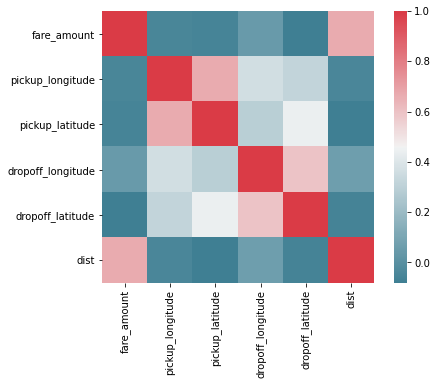

In [96]:
#Set the width and hieght of the plot
f, ax = plt.subplots(figsize=(7, 5))

#Generate correlation matrix
corr = Train_Data_corr.corr()
print(corr)

#Plotted using seaborn library
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [97]:
#eliminate all data with the pickup and drop location points as same

Train_Data=Train_Data[np.logical_and(Train_Data['pickup_longitude'] != Train_Data['dropoff_longitude'],
                                     Train_Data['pickup_latitude'] != Train_Data['dropoff_latitude'])]

# Model Development

# Decision Tree

In [98]:
#Load libraries
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

In [99]:
# Divide the data into train and test
train1, test1 = train_test_split(Train_Data, test_size=0.2)


In [100]:
# Decision tree for regression
fit_DT = DecisionTreeRegressor(max_depth=2).fit(train1.iloc[:, 1:7], train1.iloc[:,0])

In [101]:
fit_DT

DecisionTreeRegressor(max_depth=2)

In [102]:
#Apply model on test data
predictions_DT = fit_DT.predict(test1.iloc[:,1:7])


In [103]:
#Calculate MAPE
def MAPE(y_true, y_pred): 
    mape = np.mean(np.abs((y_true - y_pred) / y_true))*100
    return mape

In [104]:
MAPE(test1.iloc[:,0], predictions_DT)


29.097108482169997

# Random Forest

In [106]:
#Random Forest
from sklearn.ensemble import RandomForestRegressor



In [107]:
RF_model = RandomForestRegressor(n_estimators = 10).fit(train1.iloc[:, 1:7], train1.iloc[:,0])


In [108]:
RF_model

RandomForestRegressor(n_estimators=10)

In [109]:
RF_Predictions = RF_model.predict(test1.iloc[:, 1:7])

In [110]:
MAPE(test1.iloc[:,0], RF_Predictions)

24.798128713490335

# Linear Regression

In [112]:
#Combine all the values in one array
values=['fare_amount', 'pickup_longitude','pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'dist']


In [113]:
linear_Data = Train_Data[values]


In [114]:
#This function is developed to get columns for specific passenger count. The idea is developed from R linear regression fit, 
#which explains all the passenger count individualy contributes in the model 

cat_names = ['passenger_count'] 
for i in cat_names:
    temp = pd.get_dummies(Train_Data[i], prefix= i)
    linear_Data = linear_Data.join(temp)

In [115]:
linear_Data.shape

(14795, 12)

In [116]:
linear_Data.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,dist,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6
0,4.5,-73.981697,40.721319,-73.980230,40.712278,1.012886,1,0,0,0,0,0
1,16.9,-74.016048,40.711303,-73.979268,40.782004,8.450134,1,0,0,0,0,0
2,5.7,-73.982738,40.761270,-73.991242,40.750562,1.389525,0,1,0,0,0,0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,2.799270,1,0,0,0,0,0
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1.999157,1,0,0,0,0,0


In [117]:
#Spliting the newly created data set with passenger count dummies
train1, test1 = train_test_split(linear_Data, test_size=0.2)

In [118]:
#Import libraries for LR
import statsmodels.api as sm

In [119]:
# Train the model using the training sets
model = sm.OLS(train1.iloc[:, 0].astype(float), train1.iloc[:, 1:12].astype(float)).fit()

In [120]:
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            fare_amount   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     998.4
Date:                Tue, 21 Sep 2021   Prob (F-statistic):               0.00
Time:                        00:20:11   Log-Likelihood:                -32630.
No. Observations:               11836   AIC:                         6.528e+04
Df Residuals:                   11825   BIC:                         6.536e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
pickup_longitude    -12.4623      3.037     -4.103      0.000     -18.416      -6.508
pickup_latitude       9.7420      2.333      4.176      0.000       5.169      14.314
dropoff_longitude    17.0345      2.675      6.367      0.000      11.790      22.279
dropoff_latitude    -17.5499      2.098     -8.367      0.000     -21.661     -13.438
dist                  2.0000      0.021     97.130      0.000       1.960       2.040
passenger_count_1   661.0094    336.085      1.967      0.049       2.227    1319.792
passenger_count_2   661.0649    336.087      1.967      0.049       2.279    1319.851
passenger_count_3   661.0856    336.091      1.967      0.049       2.293    1319.878
passenger_count_4   661.0314    336.089      1.967      0.049       2.243    1319.820
passenger_count_5   660.9610    336.086      1.967      0.049       2.177    1319.745
passenger_count_6   661.9046    336.086      1.969      0.049       3.121    1320.688
==============================================================================
Omnibus:                     5913.799   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            44406.189
Skew:                           2.292   Prob(JB):                         0.00
Kurtosis:                      11.308   Cond. No.                     2.81e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.81e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [121]:
# make the predictions by the model
predictions_LR = model.predict(test1.iloc[:,1:12])


In [122]:
#Calculate MAPE
MAPE(test1.iloc[:,0], predictions_LR)

26.446484019498566

# KNN Imputation

In [124]:
#KNN implementation
from sklearn.neighbors import KNeighborsRegressor

KNN_model = KNeighborsRegressor(n_neighbors = 1).fit(train1.iloc[: , 1:7], train1.iloc[:, 0])



In [125]:
#predict test cases
KNN_Predictions = KNN_model.predict(test1.iloc[: , 1:7])


In [126]:
MAPE(test1.iloc[:,0], KNN_Predictions)

33.51768135397657

# Prediction on original test data

In [128]:
pred=(pd.read_csv('test.csv', header = 0 )).drop(columns="pickup_datetime")

In [129]:
#create Dist variable
pred['dist'] = \
    haversine( pred['pickup_latitude'], pred['pickup_longitude'],
                 pred['dropoff_latitude'], pred['dropoff_longitude'])

pred['fare_amount']=0
pred['passenger_count']=pred['passenger_count'].astype('category')

In [130]:
# Build model on the entire Train data
RF_model = RandomForestRegressor(n_estimators = 10).fit(Train_Data.iloc[:, 1:7], Train_Data.iloc[:,0])

#predict value
pred['fare_amount'] = RF_model.predict(pred.iloc[:, 0:6])

In [131]:
pred.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist,fare_amount
0,-73.973320,40.763805,-73.981430,40.743835,1,2.323259,10.91
1,-73.986862,40.719383,-73.998886,40.739201,1,2.425353,7.79
2,-73.982524,40.751260,-73.979654,40.746139,1,0.618628,3.92
3,-73.981160,40.767807,-73.990448,40.751635,1,1.961033,8.19
4,-73.966046,40.789775,-73.988565,40.744427,1,5.387301,14.96


In [132]:
#write output to csv

pred.to_csv("Predicted_Values.csv", index = False)